# Transcription factor motif matches on STARR-seq dataset

We will match the results of a genome-wide scan of transcription factor binding profiles to the sequence bins of a STARRseq dataset, and explore the resulting hits.

## Setup

### Imports

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import duckdb
import matplotlib.pyplot as plt
import seaborn as sns

### Paths for data and databases

In [3]:
PROJECT_ROOT = Path('/hpc/group/igvf')
DB_ROOT = PROJECT_ROOT / 'db'
DATA_ROOT = Path('../igvf-pm')
MOTIFS_DB = DB_ROOT / 'motifs'
STARR_DS = 'K562'
STARR_DB = DB_ROOT / f'{STARR_DS}db'

## TF motif matches from genome-wide scan

Open the database of significant matches (currently defined as p≤1e-8, corresponding to a q-value of ~0.05).

In [4]:
motifs_db_signif = duckdb.read_parquet(f'{MOTIFS_DB}-signif.parquet')

### Number of motif matches

In [4]:
motifs_db_signif.count('motif_id')

┌─────────────────┐
│ count(motif_id) │
│      int64      │
├─────────────────┤
│          723249 │
└─────────────────┘

### Number of matches per motif

In [5]:
motif_matches = duckdb.sql(
    'select motif_id, regexp_extract(motif_alt_id, \'\.([^\.]+)$\', 1) as motif_name, '
    'count(*) as num_matches, '
    'from motifs_db_signif '
    'group by motif_id, motif_alt_id '
    'order by count(*) desc').df()
with pd.option_context('display.max_rows', None):
    display(motif_matches)

,motif_id,motif_name,num_matches
0,MA1596.1,ZNF460,439545
1,MA0149.1,EWSR1-FLI1,132769
2,MA1718.1,ZNF8,54149
3,MA1594.1,ZNF382,20845
4,MA2335.1,ZNF558,14191
5,MA1978.2,ZNF354A,11770
6,MA0080.5,SPI1,11728
7,MA1589.2,ZNF140,5572
8,MA1587.1,ZNF135,4622
9,MA1654.2,ZNF16,1805


### TF pairs within ≤K bp of each other

Loosely inspired by the typical insert length in STARRseq experiments, we set K = 1000.

In [41]:
TFpairs = duckdb.sql('select m1.chrom, m1.start, m1.stop - m1.start as motif_length, '
           'm1.motif_id, regexp_extract(m1.motif_alt_id, \'\.([^\.]+)$\', 1) as motif_name, '
           'm2.motif_id as motif2_id, regexp_extract(m2.motif_alt_id, \'\.([^\.]+)$\', 1) as motif2_name, '
           'm2.start - m1.start as motif_distance '
           'from motifs_db_signif m1 join motifs_db_signif m2 '
           'on (m1.chrom = m2.chrom and m1.stop < m2.start and m1.start + 1000 >= m2.stop)').df()
TFpairs

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,chrom,start,motif_length,motif_id,motif_name,motif2_id,motif2_name,motif_distance
0,chr1,7995162,17,MA0149.1,EWSR1-FLI1,MA1596.1,ZNF460,744
1,chr1,7995162,17,MA0149.1,EWSR1-FLI1,MA0149.1,EWSR1-FLI1,81
2,chr1,7995162,17,MA0149.1,EWSR1-FLI1,MA0149.1,EWSR1-FLI1,77
3,chr1,7995162,17,MA0149.1,EWSR1-FLI1,MA0149.1,EWSR1-FLI1,20
4,chr1,7988162,15,MA1596.1,ZNF460,MA1596.1,ZNF460,383
...,...,...,...,...,...,...,...,...
790253,chrY,25512817,15,MA1596.1,ZNF460,MA1596.1,ZNF460,136
790254,chrY,25496667,15,MA1596.1,ZNF460,MA1596.1,ZNF460,144
790255,chrY,25453236,19,MA1718.1,ZNF8,MA2335.1,ZNF558,443
790256,chrY,25444063,19,MA0080.5,SPI1,MA1594.1,ZNF382,876


#### TF pair statistics

In [42]:
TFpair_stats = duckdb.sql('select motif_id, motif_name, motif2_name, '
           'count(*) as numpairs, '
           'min(motif_distance) as min_distance, '
           'max(motif_distance) as max_distance, '
           'median(motif_distance) as median_distance, '
           'round(avg(motif_distance), 1) as avg_distance '
           'from TFpairs '
           'group by motif_id, motif_name, motif2_name '
           'having numpairs > 1 '
           'order by motif_name').df()
TFpair_stats

,motif_id,motif_name,motif2_name,numpairs,min_distance,max_distance,median_distance,avg_distance
0,MA0007.2,AR,ZNF460,18,53,968,712.0,657.3
1,MA1470.2,BACH2,ZNF460,7,245,447,311.0,333.0
2,MA0731.1,BCL6B,ZNF135,2,717,883,800.0,800.0
3,MA0731.1,BCL6B,ZNF460,10,271,807,624.0,556.2
4,MA1929.2,CTCF,ZNF140,3,506,954,749.0,736.3
...,...,...,...,...,...,...,...,...
623,MA2100.1,ZSCAN16,ZNF460,9,98,964,580.0,563.2
624,MA1722.2,ZSCAN31,ZNF8,2,189,479,334.0,334.0
625,MA1722.2,ZSCAN31,ZNF460,11,213,849,449.0,474.3
626,MA1155.1,ZSCAN4,ZNF460,14,344,967,552.5,601.4


#### Some pairs occur 1000s of times

In [44]:
TFpair_stats[TFpair_stats['numpairs'] > 1000]

,motif_id,motif_name,motif2_name,numpairs,min_distance,max_distance,median_distance,avg_distance
64,MA0149.1,EWSR1-FLI1,ZNF460,27508,21,985,414.0,469.0
73,MA0149.1,EWSR1-FLI1,EWSR1-FLI1,523882,18,983,68.0,126.2
94,MA0149.1,EWSR1-FLI1,ZNF8,1321,20,981,653.0,654.4
263,MA0080.5,SPI1,ZNF382,3727,136,977,876.0,868.8
318,MA1587.1,ZNF135,ZNF460,1747,22,985,419.0,437.7
336,MA1589.2,ZNF140,ZNF460,1114,65,985,590.0,574.8
403,MA1594.1,ZNF382,SPI1,3751,111,979,880.0,873.6
424,MA1596.1,ZNF460,ZNF460,152847,16,985,426.0,448.1
444,MA1596.1,ZNF460,ZNF558,1055,52,971,563.0,557.4
480,MA1596.1,ZNF460,ZNF8,4894,50,981,588.5,584.9


#### But most occur <50 times

Text(0.5, 1.0, 'Distribution of multiply occurring TF pairs')

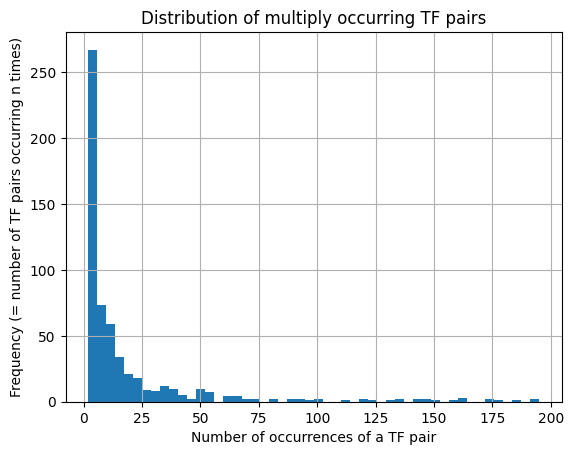

In [43]:
TFpair_stats[TFpair_stats['numpairs'] <= 200].hist(column='numpairs', bins=50)
plt.xlabel('Number of occurrences of a TF pair')
plt.ylabel('Frequency (= number of TF pairs occurring n times)')
plt.title('Distribution of multiply occurring TF pairs')

#### Distribution of motif pair distances in TF pairs

(1000.0, 100000.0)

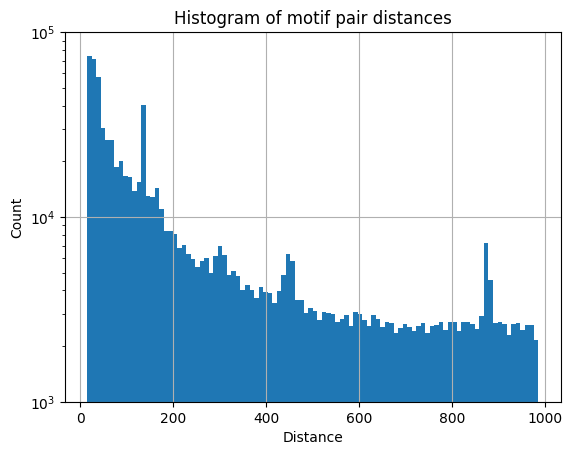

In [43]:
ax = TFpairs.hist('motif_distance', bins=100)[0][0]
ax.set_title('Histogram of motif pair distances')
ax.set_xlabel('Distance')
ax.set_ylabel('Count')
ax.set_yscale('log')
ax.set_ylim(1e3, 1e5)

This could suggest that there is a bias towards shorter distances, but it turns out the distribution in the short distance range is dominated by a single TF pair (EWSR1-FLI1 paired with itself). Once we remote this, there is no clear bias anymore.

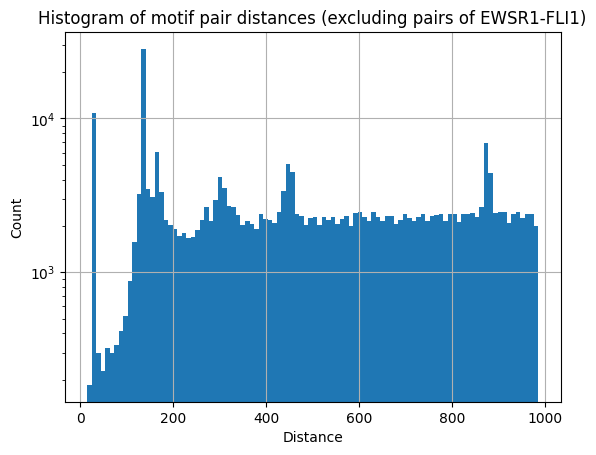

In [44]:
TFpairs_filtered = TFpairs.loc[~((TFpairs['motif_id'] == 'MA0149.1') & (TFpairs['motif2_id'] == 'MA0149.1'))]        
ax = TFpairs_filtered.hist('motif_distance', bins=100)[0][0]
ax.set_title('Histogram of motif pair distances (excluding pairs of EWSR1-FLI1)')
ax.set_xlabel('Distance')
ax.set_ylabel('Count')
ax.set_yscale('log')

## Motif matches mapped to STARRseq sequence bins

Load the STARRseq data:

In [4]:
data_db = duckdb.read_parquet(f"{STARR_DB}/**/*.parquet",
                              hive_partitioning=True)

Match motif matches to STARRseq sequence bins. We require that a motif lies fully within the sequence bin.

In [79]:
hits_db = duckdb.sql('select d.chrom, d.start as seq_start, d.end as seq_end, '
           'm.motif_id, m.motif_alt_id, '
           'regexp_extract(m.motif_alt_id, \'\.([^\.]+)$\', 1) as motif_name, '
           'm.start as mot_start, m.stop as mot_stop, d.log2FC, d.train, d.test '
           'from data_db as d '
           'join motifs_db_signif as m '
           'on (d.chrom = m.chrom and d.start <= m.start and d.end >= m.stop)')
hits_db.to_parquet(f'{MOTIFS_DB}-{STARR_DS}_hits.parquet')

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

We write this to a Parquet database so we can easily reload it later:

In [6]:
hits_db = duckdb.read_parquet(f'{MOTIFS_DB}-{STARR_DS}_hits.parquet')

How many sequence bins with at least one TF motif match do we have?

In [81]:
hits_db.count('chrom')

┌──────────────┐
│ count(chrom) │
│    int64     │
├──────────────┤
│       922087 │
└──────────────┘

In [6]:
starr_sample = duckdb.sql('select chrom, start, log2FC from data_db using sample 1000000').df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

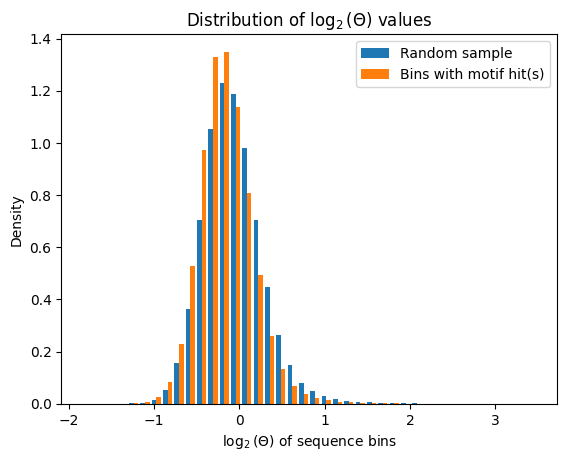

In [38]:
h = plt.hist((starr_sample['log2FC'], hits_db.df()['log2FC']),
             density=True, bins=40, label=('Random sample', 'Bins with motif hit(s)'))
plt.xlabel('$\log_2(\Theta)$ of sequence bins')
plt.ylabel('Density')
plt.title('Distribution of $\log_2(\Theta)$ values')
plt.legend()

### Per-motif statistics: number of sequence bins, median $\log_2(\theta)$ etc

In [7]:
hit_stats = duckdb.sql('select mh.motif_id, mh.motif_name, '
           'count(*) as num_hits, '
           'count(case when train = \'true\' then 1 else NULL end) as train_hits, '
           'count(case when test = \'true\' then 1 else NULL end) as test_hits, '
           'median(log2FC) as median_log2FC, '
           'quantile(log2FC, 0.75) as q75_log2FC, '
           'quantile(log2FC, 0.95) as q95_log2FC '
           'from hits_db mh '
           'group by mh.motif_id, mh.motif_alt_id, mh.motif_name ').df()
with pd.option_context('display.max_rows', None):
    display(hit_stats.sort_values('num_hits', ascending=False).reset_index(drop=True))

,motif_id,motif_name,num_hits,train_hits,test_hits,median_log2FC,q75_log2FC,q95_log2FC
0,MA1596.1,ZNF460,675668,90134,87223,-0.184750,0.00993,0.31698
1,MA0149.1,EWSR1-FLI1,68472,8999,9455,-0.224260,-0.00791,0.33444
2,MA1718.1,ZNF8,64020,8399,8154,-0.328950,-0.15726,0.12583
3,MA1587.1,ZNF135,9050,1235,1218,-0.156385,0.03495,0.35750
4,MA1589.2,ZNF140,8661,1148,1110,-0.173360,0.02250,0.32437
5,MA1654.2,ZNF16,7903,1058,1045,-0.071720,0.15910,0.51827
6,MA1573.1,THAP11,6507,863,867,0.496160,0.88891,1.44062
7,MA1929.2,CTCF,4673,614,662,0.154930,0.41024,0.82280
8,MA1930.2,CTCF,4409,624,597,0.085490,0.34712,0.83508
9,MA1723.2,PRDM9,3966,527,531,0.015810,0.28159,0.70043


### Distribution of activations per motif

We would expect that far less than all motifs show elevated activations in any given STARR-seq dataset (i.e., cell-line and treatment). Therefore, we will limit ourselves to looking a reasonably small number of motifs which for simplicity we refer to as "active". We define this as having a median activation higher than some threshold.

In [8]:
med_log2FC_thresh = 0.1
activeTFs = hit_stats[hit_stats['median_log2FC'] >= med_log2FC_thresh].sort_values('median_log2FC')
with pd.option_context('display.max_rows', None):
    display(activeTFs.reset_index(drop=True))

,motif_id,motif_name,num_hits,train_hits,test_hits,median_log2FC,q75_log2FC,q95_log2FC
0,MA1470.2,BACH2,32,5,6,0.103590,0.27450,0.33917
1,MA0697.1,ZIC3,55,9,5,0.112420,0.38268,0.79602
2,MA0065.1,PPARG::RXRA,577,85,91,0.113520,0.39910,0.78997
3,MA1597.1,ZNF528,2272,310,320,0.115010,0.30762,0.60622
4,MA1491.3,GLI3,31,5,5,0.118580,0.24338,0.73008
5,MA1556.1,RXRG,170,13,17,0.123635,0.46230,0.77379
6,MA0779.2,PAX1,10,2,3,0.126820,0.19207,0.19229
7,MA0784.3,POU1F1,360,44,48,0.132865,0.42512,1.12946
8,MA0159.1,RARA::RXRA,282,30,36,0.137975,0.34286,0.77372
9,MA1967.2,TFAP4::FLI1,19,3,4,0.138320,0.18636,0.25204


We can now extract those sequence bins whose motif match(es) are among those motifs we consider "active".

In [86]:
activeTFseqs = duckdb.sql(
    'select hdb.motif_id, hdb.motif_name, '
    'chrom, seq_start, mot_start, mot_stop, log2FC, train, test '
    'from hits_db hdb join activeTFs atf on (hdb.motif_id = atf.motif_id)').df()

With this subset we make a boxplot of activations vs. motifs:

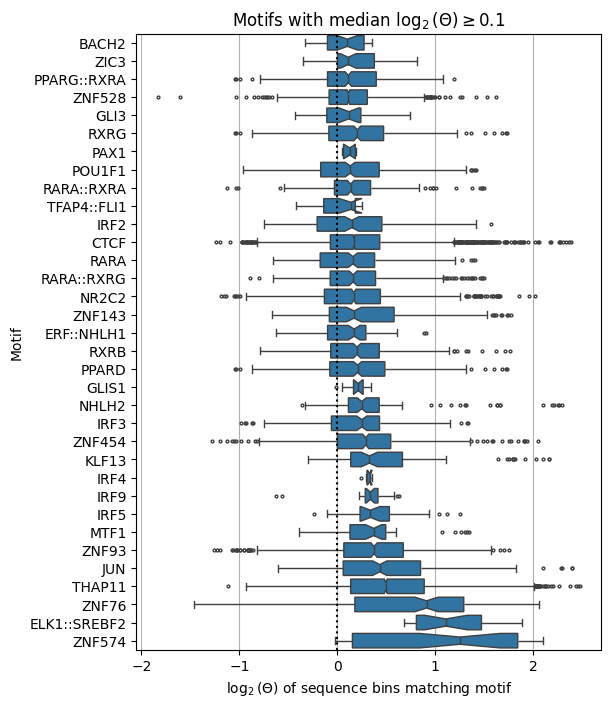

In [87]:
fig, ax = plt.subplots(figsize=(6, 8))
sns.boxplot(y='motif_name', x='log2FC', data=activeTFseqs,
            order=activeTFs['motif_name'], fliersize=2, notch=True, ax=ax)
ax.set_title(f'Motifs with median $\log_2(\Theta)\geq {med_log2FC_thresh}$')
ax.set_ylabel('Motif')
ax.set_xlabel('$\log_2(\Theta)$ of sequence bins matching motif')
ax.xaxis.grid(True)
ax.axvline(0, color='black', linestyle='dotted')

### Motif pair distances for "active" motifs

We consider pairs where at least one of the motifs is among those we consider "active".

Text(0, 0.5, 'Count')

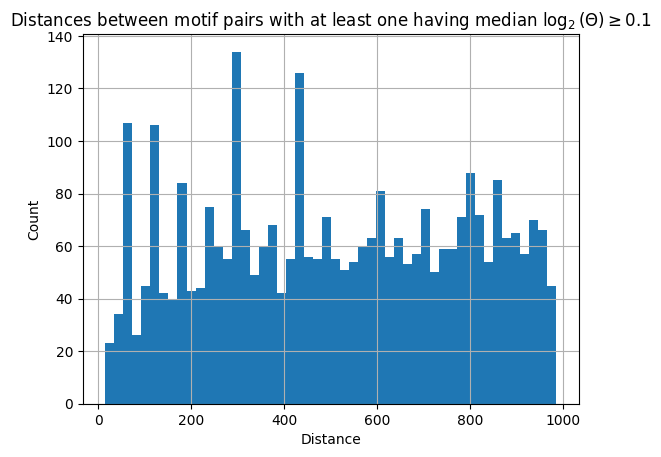

In [45]:
TFpairs_active = TFpairs.loc[TFpairs['motif_id'].isin(activeTFs['motif_id']) | 
                             TFpairs['motif2_id'].isin(activeTFs['motif_id'])]
ax = TFpairs_active.hist('motif_distance', bins=50)[0][0]
ax.set_title('Distances between motif pairs with at least one having median $\log_2(\Theta)\geq 0.1$')
ax.set_xlabel('Distance')
ax.set_ylabel('Count')

### Sequence bins with combinations of TF motifs

Here we define motif combinations as the particular combination of motif hits (_num\_hits_) for the same sequence bin. Motif combinations can consist of hits by the same or different motifs.

We consider TF motifs different (_num\_tfs_) if their motif IDs are different. Different motif IDs can still have the same name as a part of their _alt ID_. We report the motif names both in "natural" and in lexical order.

For accepting a motif to be part of the combination for the sequence bin, we require that the last (by position) motif falling into a sequence bin starts after the first motif falling into the bin ends. I.e., at least the first and the last along the sequence bin don't overlap (but for a combination of _more_ than 2 motifs, others, such as the first and the second, may overlap).

In [9]:
TFcomb_hits = duckdb.sql('select chrom, seq_start, seq_end, '
           'count(*) as num_hits, count(distinct motif_id) as num_tfs, '
           'max(mot_start) - min(mot_start) as max_motif_dist, '
           'group_concat(motif_name, \', \') as motif_names, '
           'group_concat(motif_name, \', \' order by motif_name) as motif_names_o, '
           'first(log2FC) as log2FC, '
           'first(case when train = \'true\' then TRUE else FALSE end) as train, '
           'first(case when test = \'true\' then TRUE else FALSE end) as test, '
           'from hits_db mh '
           'group by chrom, seq_start, seq_end '
           'having num_hits > 1 and max(mot_start) > min(mot_stop) '
           'order by chrom, seq_start').df()
# TFcomb_hits.to_csv(f'{MOTIFS_DB}-{STARR_DS}_TFcomb_hits.csv', index=False)
TFcomb_hits.drop(columns=['motif_names_o'])

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,chrom,seq_start,seq_end,num_hits,num_tfs,max_motif_dist,motif_names,log2FC,train,test
0,chr1,181550,181850,3,2,58,"CTCF, CTCF, CTCF",0.13608,False,True
1,chr1,946704,947004,2,1,134,"ZNF460, ZNF460",-0.13489,True,True
2,chr1,946754,947054,2,1,134,"ZNF460, ZNF460",-0.15606,False,True
3,chr1,946804,947104,2,1,134,"ZNF460, ZNF460",-0.18760,False,False
4,chr1,957904,958204,2,1,32,"ZNF460, ZNF460",-0.22449,True,True
...,...,...,...,...,...,...,...,...,...,...
54763,chrX,154962524,154962824,2,1,135,"ZNF460, ZNF460",0.09518,False,False
54764,chrX,154962574,154962874,2,1,135,"ZNF460, ZNF460",0.16714,False,False
54765,chrX,155894624,155894924,2,1,135,"ZNF460, ZNF460",-0.34785,False,False
54766,chrX,155894674,155894974,2,1,135,"ZNF460, ZNF460",-0.29930,False,False


#### Some statistics for motif combinations

How many multiple motif hits to a sequence bin do we have, and does this compare to all motif hits (single motif and multiple motif matches combined)?

In [138]:
seqs_with_motif = hits_db.count('chrom').fetchall()[0][0]
print(f'Of the {seqs_with_motif} sequence bins with a motif hit, {len(TFcomb_hits)/seqs_with_motif:.1%} ({len(TFcomb_hits)}) have more than one.')

Of the 922087 sequence bins with a motif hit, 5.9% (54768) have more than one.


For each number of motif matches per sequnce bin, how many sequences bins with this many motif matches?

Note that the vast majority of seqence bins have only one motif match, and the vast majority of motif combinations are pairs.

In [115]:
TFcomb_hits['num_tfs'].value_counts()

num_tfs
1    48998
2     5677
3       70
4       15
6        5
5        3
Name: count, dtype: int64

TF combinations that are (and are not) included in the training set and the test set:

In [116]:
TFcomb_hits['train'].value_counts()

train
False    47595
True      7173
Name: count, dtype: int64

In [117]:
TFcomb_hits['test'].value_counts()

test
False    47675
True      7093
Name: count, dtype: int64

### Frequency, activations, and other statistics for motif combinations

Note that for these statistics, we use the lexically ordered motif names making up the combination, meaning we will ignore the order of motifs in the combination for treating combinations as the same or different, and will also ignore the motif's IDs.

In [10]:
TFcomb_stats = duckdb.sql(
    'select mh.motif_names_o as motif_names, first(num_hits) as num_motifs, first(num_tfs) as num_tfs, '
    'count(*) as num_seqs, '
    'count(case when train = \'true\' then 1 else NULL end) as train_seqs, '
    'count(case when test = \'true\' then 1 else NULL end) as test_seqs, '
    'median(log2FC) as median_log2FC, '
    'quantile(log2FC, 0.75) as q75_log2FC, '
    'quantile(log2FC, 0.95) as q95_log2FC '
    'from TFcomb_hits mh '
    'group by mh.motif_names_o ').df()
TFcomb_stats.drop(columns=['num_motifs']).sort_values('median_log2FC', ascending=False).reset_index(drop=True).head(25)

,motif_names,num_tfs,num_seqs,train_seqs,test_seqs,median_log2FC,q75_log2FC,q95_log2FC
0,"CTCF, CTCF, CTCF, CTCF",2,5,2,2,1.802750,1.86951,1.89925
1,"THAP11, THAP11, THAP11",1,3,1,0,1.450910,2.06671,2.06671
2,"ZNF93, ZNF93, ZNF93",1,3,0,0,1.326960,1.38083,1.38083
3,"RARA::RXRA, RARA::RXRG, ZNF460",3,2,0,0,1.294880,1.37339,1.37339
4,"PRDM9, THAP11",2,5,1,0,1.099430,1.21100,1.23865
5,"THAP11, ZNF93",2,3,0,0,1.060220,1.11753,1.11753
6,"CTCF, THAP11",2,6,0,2,1.044685,1.07620,1.08023
7,"SPI1, THAP11",2,4,0,0,1.039605,1.05678,1.05971
8,"EWSR1-FLI1, ZNF76",2,2,0,0,1.016960,1.05902,1.05902
9,"KLF13, THAP11",2,3,0,0,0.983970,1.02661,1.02661


#### A small number of motif combinations occur 100s or 1000s of times

In [11]:
TFcomb_stats[TFcomb_stats['num_seqs'] > 200].drop(columns=['num_motifs']).reset_index(drop=True)

,motif_names,num_tfs,num_seqs,train_seqs,test_seqs,median_log2FC,q75_log2FC,q95_log2FC
0,"ZNF460, ZNF460, ZNF460",1,1006,110,125,-0.203145,-0.01123,0.31827
1,"EWSR1-FLI1, EWSR1-FLI1, EWSR1-FLI1, EWSR1-FLI1...",1,218,22,28,-0.212120,0.02484,0.31161
2,"ZNF460, ZNF8",2,547,69,84,-0.287790,-0.09028,0.15015
3,"EWSR1-FLI1, EWSR1-FLI1, EWSR1-FLI1, EWSR1-FLI1",1,494,75,71,-0.256465,-0.05503,0.19394
4,"ZNF140, ZNF8",2,638,91,90,-0.188410,-0.01246,0.23812
5,"ZNF135, ZNF460",2,1332,194,180,-0.172545,0.04468,0.33437
6,"EWSR1-FLI1, EWSR1-FLI1, EWSR1-FLI1, EWSR1-FLI1...",1,688,105,97,-0.244675,-0.06100,0.26074
7,"EWSR1-FLI1, EWSR1-FLI1, EWSR1-FLI1, EWSR1-FLI1...",1,397,45,57,-0.286940,-0.07473,0.22698
8,"EWSR1-FLI1, EWSR1-FLI1, EWSR1-FLI1, EWSR1-FLI1...",1,443,68,61,-0.289200,-0.10821,0.26614
9,"THRA, ZNF460",2,284,24,33,-0.162075,0.00945,0.34119


#### But most occur less than 20 times

Text(0, 0.5, 'Count (of motif combinations matching n sequence bins)')

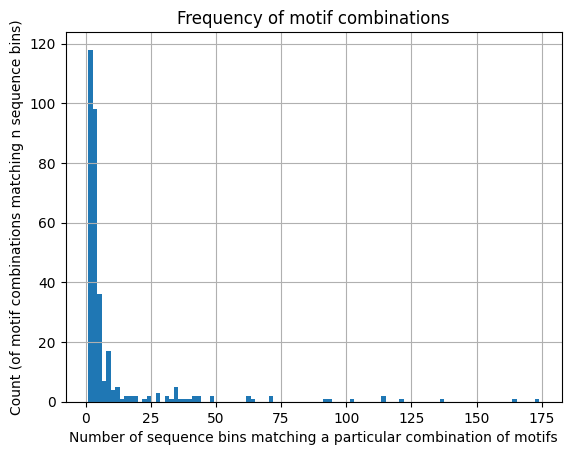

In [14]:
ax = TFcomb_stats[TFcomb_stats['num_seqs'] <= 200].hist(column='num_seqs', bins=100)[0][0]
ax.set_title('Frequency of motif combinations')
ax.set_xlabel('Number of sequence bins matching a particular combination of motifs')
ax.set_ylabel('Count (of motif combinations matching n sequence bins)')

#### Distribution of activations per motif combination

As for individual motifs (or TFs), we would expect that far less than all motif combinations show elevated activations in any given STARR-seq dataset (i.e., cell-line and treatment).

Therefore, as we did for individual motifs, to limit ourselves to a reasonably small number of motif combinations which for simplicity we refer to as "active", we define "active" as having a median activation higher than some threshold.

Recall that here the order of motifs in a combination is ignored for deciding whether two combinations are the same. 

In [11]:
med_log2FC_thresh = 0.0
activeTFcombs = TFcomb_stats[(TFcomb_stats['median_log2FC'] >= med_log2FC_thresh) &
                             (TFcomb_stats['num_seqs'] >= 5)].sort_values('median_log2FC')
with pd.option_context('display.max_rows', None):
    display(activeTFcombs.drop(columns=['num_motifs']).reset_index(drop=True))

,motif_names,num_tfs,num_seqs,train_seqs,test_seqs,median_log2FC,q75_log2FC,q95_log2FC
0,"SOX21, ZNF460",2,5,0,0,0.012880,0.05600,0.07084
1,"ZKSCAN3, ZNF460",2,5,0,0,0.028330,0.19083,0.37812
2,"CTCF, ZNF460",2,63,5,7,0.038550,0.28478,0.57909
3,"ZSCAN4, ZSCAN4",1,5,0,2,0.040240,0.07757,0.15878
4,"EWSR1-FLI1, PRDM9",2,8,1,0,0.040440,0.04871,0.11138
5,"ZNF707, ZNF707, ZNF707",1,5,2,1,0.082030,0.17264,0.25252
6,"CTCF, CTCF",1,65,6,7,0.112160,0.54911,0.89224
7,"CTCF, RREB1",2,12,3,2,0.147200,0.16738,0.44381
8,"CTCF, EWSR1-FLI1",2,11,4,1,0.153560,0.28245,0.37621
9,"ZIC1, ZIC3, ZNF675",3,5,1,1,0.169100,0.20457,0.21638


Using the list of "active" motif combinations, we subset the sequence bins to those matching those combinations.

In [12]:
activeTFcomb_hits = duckdb.sql(
    'select atf.motif_names, chrom, seq_start, log2FC, train, test '
    'from TFcomb_hits hdb join activeTFcombs atf on (hdb.motif_names_o = atf.motif_names)').df()

Now we can plot the distribution of activations per motif combination for each combination in the list. (Note that the majority of these motif combinations are motif pairs.)

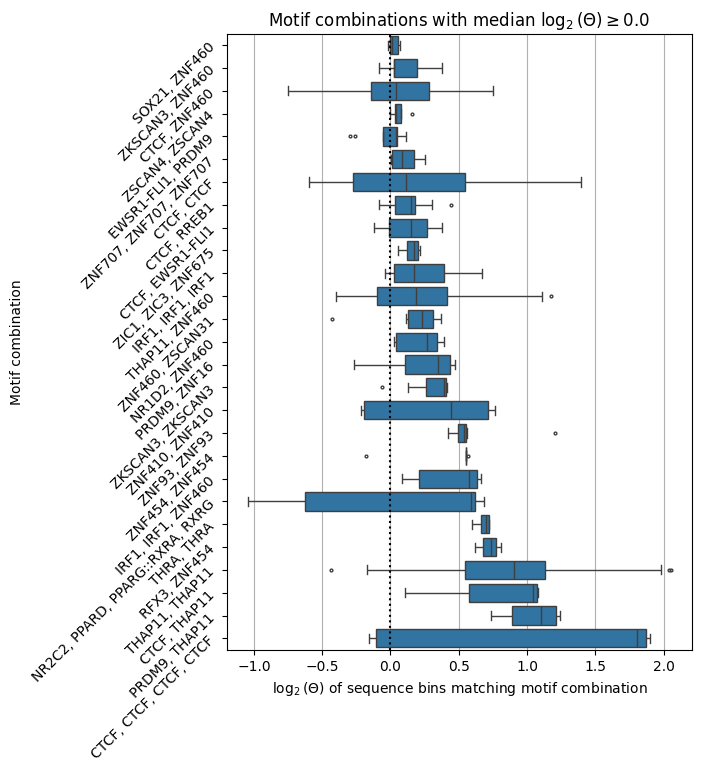

In [13]:
fig, ax = plt.subplots(figsize=(6, 8))
sns.boxplot(y='motif_names', x='log2FC', data=activeTFcomb_hits,
            order=activeTFcombs['motif_names'], fliersize=2, ax=ax)
ax.set_title(f'Motif combinations with median $\log_2(\Theta)\geq {med_log2FC_thresh}$')
ax.set_ylabel('Motif combination')
ax.tick_params(axis='y', labelrotation=45)
ax.set_xlabel('$\log_2(\Theta)$ of sequence bins matching motif combination')
ax.xaxis.grid(True)
ax.axvline(0, color='black', linestyle='dotted')

#### Distribution of activations for sequence bins with TF motif hits

We compare all sequence bins with TF motif hit(s) with those with a combination of TF motifs, and the background distribution of sequence bins. 

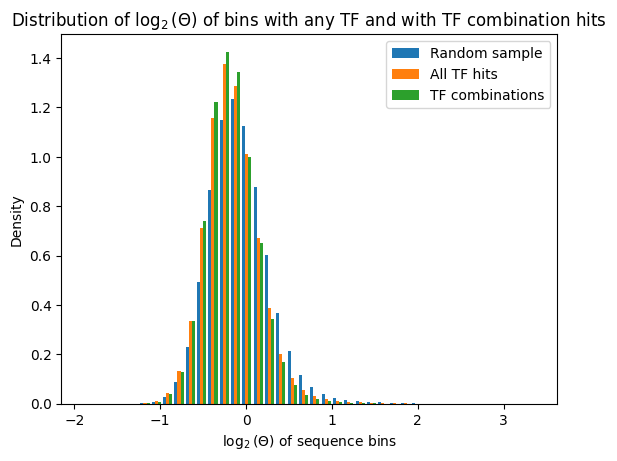

In [14]:
h = plt.hist((starr_sample['log2FC'],
              hits_db.df()['log2FC'],
              TFcomb_hits['log2FC']),
             bins=40, density=True, label=('Random sample', 'All TF hits', 'TF combinations'))
plt.xlabel('$\log_2(\Theta)$ of sequence bins')
plt.ylabel('Density')
plt.title('Distribution of $\log_2(\Theta)$ of bins with any TF and with TF combination hits')
plt.legend(loc='upper right')

### Distribution of distances for motif combinations in sequence bins

Distances are between pairs of motifs. However, recall that the distances we calculated are for the maximum distance between a pair in a combination. For combinations that are pairs, this is the same as the motif pair distance, but for combinations of more than 2 motifs, we are not enumerating the distances between all possible pairs.

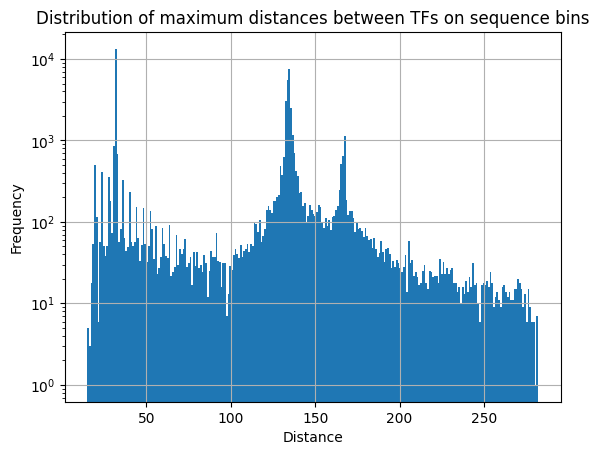

In [ ]:
h = plt.hist(TFcomb_hits['max_motif_dist'], bins=260, log=True)
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.title('Distribution of maximum distances between motifs on sequence bins')
plt.grid(True)


The overall distribution is distorted by a few TF motif combinations predominating at certain distances (such as pairs of ZNF460, and ZNF460 with ZNF135).

In [191]:
duckdb.sql('select motif_names, max_motif_dist, count(*) as num_seqs, '
           'sum(cast(train as int)) as in_train, sum(cast(test as int)) as in_test, '
           'median(log2FC), '
           'from TFcomb_hits '
           'group by motif_names, max_motif_dist '
           'having num_seqs > 300').df()

,motif_names,max_motif_dist,num_seqs,in_train,in_test,median(log2FC)
0,"ZNF460, ZNF460",133,3036,383.0,379.0,-0.205165
1,"ZNF135, ZNF460",33,459,72.0,68.0,-0.167750
2,"ZNF460, ZNF460",140,321,38.0,50.0,-0.187760
3,"ZNF460, ZNF460",136,2437,316.0,313.0,-0.198370
4,"ZNF460, ZNF460",138,656,87.0,83.0,-0.226905
5,"ZNF460, ZNF460",167,463,66.0,61.0,-0.207700
6,"ZNF460, ZNF460",131,340,57.0,49.0,-0.167210
7,"ZNF460, ZNF460",139,383,48.0,50.0,-0.210680
8,"ZNF460, ZNF460",137,1139,167.0,147.0,-0.224830
9,"ZNF460, ZNF135",31,438,58.0,59.0,-0.182475


### Distribution of activations for motif pairs vs their distance

For a better sense of presence or absence of a statistical change over the range of distances, we divide up the distances into bins, and then create a boxplot of activations vs distance bin.

In [31]:
dist_bin_w = 10
TFcomb_dists = pd.DataFrame({
    'max_motif_dist': TFcomb_hits['max_motif_dist'],
    'dist_category': TFcomb_hits['max_motif_dist'] // dist_bin_w * dist_bin_w + dist_bin_w/2,
    'log2FC': TFcomb_hits['log2FC']})

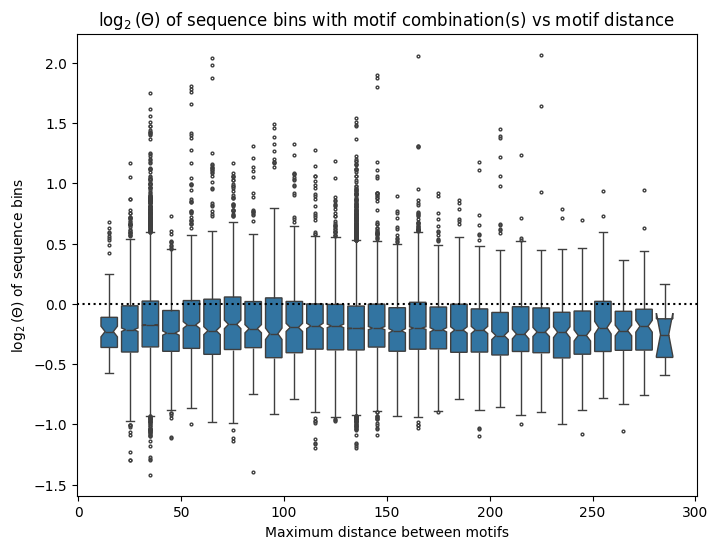

In [37]:
fig, ax = plt.subplots(figsize=(8, 6))
ax = sns.boxplot(x='dist_category', y='log2FC', data=TFcomb_dists,
                 native_scale=True, notch=True, fliersize=2)
ax.set_title('$\log_2(\Theta)$ of sequence bins with motif combination(s) vs motif distance')
ax.set_xlabel('Maximum distance between motifs')
ax.set_ylabel('$\log_2(\Theta)$ of sequence bins')
ax.axhline(0, color='black', linestyle='dotted')